In [4]:
# Remember to turn on GPU!!!
# installing packages
!pip install keras --upgrade
!pip install tensorflow --upgrade
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install kaggle-cli

# install cv2
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

# Download our data straight from Kaggle
#!kg download -u "user" -p "pass" -c data-science-bowl-2018 

# Unzip the files. -q option is for 'quiet' mode
#!unzip -q stage1_train.zip -d stage1_train


    100% |████████████████████████████████| 327kB 2.2MB/s 
    100% |████████████████████████████████| 50.0MB 28kB/s 
    100% |████████████████████████████████| 12.2MB 116kB/s 
    100% |████████████████████████████████| 256kB 4.4MB/s 
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras)
  Running setup.py bdist_wheel for pyyaml ... - \ done
  Stored in directory: /content/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1
  Found existing installation: PyYAML 3.11
    Uninstalling PyYAML-3.11:
      Successfully uninstalled PyYAML-3.11
    100% |████████████████████████████████| 45.9MB 31kB/s 
Requirement already up-to-date: astor>=0.6.0 in /usr/loca

    100% |████████████████████████████████| 81kB 2.4MB/s 
    100% |████████████████████████████████| 5.3MB 267kB/s 
    100% |████████████████████████████████| 81kB 7.9MB/s 
    100% |████████████████████████████████| 102kB 8.1MB/s 
  Running setup.py bdist_wheel for kaggle-cli ... - done
  Stored in directory: /content/.cache/pip/wheels/f0/3c/ff/c98870eeb0ca26250ce6a60dc9be23f547b7ef68b3d6a1c0b5
  Running setup.py bdist_wheel for cliff ... - done
  Stored in directory: /content/.cache/pip/wheels/27/4c/aa/0f67aa384e67aacc5629321b1a3f85892362d4e9e5cd3a20f1
  Running setup.py bdist_wheel for configparser ... - done
  Stored in directory: /content/.cache/pip/wheels/1c/bd/b4/277af3f6c40645661b4cd1c21df26aca0f2e1e9714a1d4cda8
  Running setup.py bdist_wheel for PrettyTable ... - done
  Stored in directory: /content/.cache/pip/wheels/b6/90/7b/1c22b89217d0eba6d5f406e562365ebee804f0d4595b2bdbcd
  Running setup.py bdist_wheel for cmd2 ... - done
  Stored in directory: /content/.cache/

Selecting previously unselected package libxext6:amd64.
(Reading database ... 16669 files and directories currently installed.)
Preparing to unpack .../libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../x11-common_1%3a7.7+19ubuntu3_all.deb ...
Unpacking x11-common (1:7.7+19ubuntu3) ...
Selecting previously unselected package libice6:amd64.
Preparing to unpack .../libice6_2%3a1.0.9-2_amd64.deb ...
Unpacking libice6:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libsm6:amd64.
Preparing to unpack .../libsm6_2%3a1.2.2-1_amd64.deb ...
Unpacking libsm6:amd64 (2:1.2.2-1) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up x11-common (1:7.7+19ubuntu3) ...
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.

In [10]:
!ls

datalab


# Libraries and Global Parameters 

In [6]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte, img_as_int
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout, Flatten, Conv2DTranspose
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy


####### UPDATE THIS #########
#############################

model_num = 2

#############################
#############################

model_checkpoint_file= 'unet_v' + str(model_num) +'.h5'
submission_filename = 'unet_v' + str(model_num) +'_pred.csv'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#warnings.resetwarnings()

Using TensorFlow backend.


# Preparing the Data

In [2]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ resize(image,(img_width,img_height)) for image in images] 
    Array = np.reshape(np.array(resized_images),
                       (len(resized_images),img_height,img_width,img_channels))
    #Array = np.reshape(np.array(img_as_ubyte(resized_images),dtype=np.uint8).astype(np.uint8),
    #                   (len(resized_images),img_height,img_width,img_channels))
    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs
    Array = ((Array - Array.mean())/Array.std())

    print(Array.mean())
    print(Array.std())
    print(images[0].dtype)
   # print(resized_images[0].dtype)
    print(Array[0,0,0,0].dtype)
    return Array, images, filenames, dirs

train_X, train_images, train_filenames, train_dirs = import_images(train_root)

NameError: ignored

In [0]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,img_channels))

Image #: 515


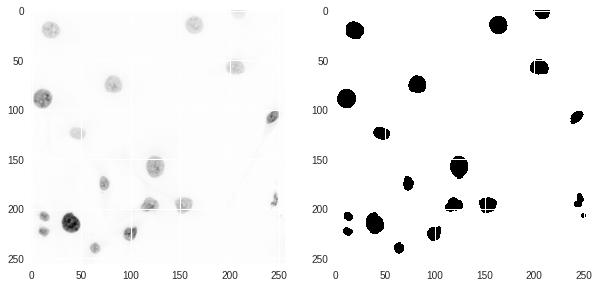

In [6]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num,size=(15,10)):
    print('Image #: ' + str(image_num))
    fig = plt.figure(figsize=size)

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None,size=(15,10)):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1),size=size)
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i],size=size)
    

plot_check([train_images,train_masks],rand_imgs=1,size=(10,7))


In [7]:
# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time

# Check physical size
print(train_X.shape)
print(train_Y.shape)

# Check memory size
print(train_X.nbytes)
print(train_Y.nbytes)

# Check datatypes
print(train_X.dtype)
print(train_Y.dtype)

(670, 128, 128, 1)
(670, 128, 128, 1)
87818240
10977280
float64
bool


Image #: 176


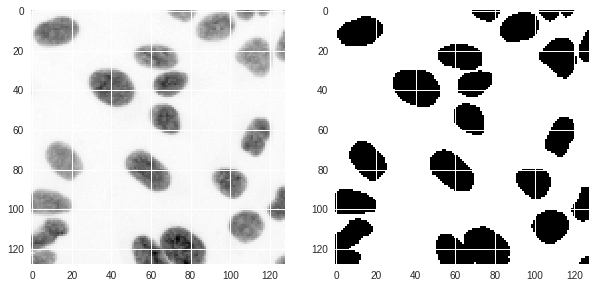

In [8]:
plot_check([np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3)],rand_imgs=1,size=(10,7))


# Now Let's Build the Model

In [9]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

  
  ## used for meshnet
def create_block(x, filters=21, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.25,l2_reg=0):
    x = Conv2D(filters, filter_size, padding='same', activation=activation, dilation_rate = dil_rate,kernel_regularizer=regularizers.l2(l2_reg)) (x)
    #x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x

  
  
  ## used for dilated unet
  
def encoder(x, filters=44, n_block=3, kernel_size=(3, 3), activation='relu'):
    skip = []
    for i in range(n_block):
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        skip.append(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x, skip


def bottleneck(x, filters_bottleneck, mode='cascade', depth=6,
               kernel_size=(3, 3), activation='relu'):
    dilated_layers = []
    if mode == 'cascade':  # used in the competition
        for i in range(depth):
            x = Conv2D(filters_bottleneck, kernel_size,
                       activation=activation, padding='same')(x)
            dilated_layers.append(x)
        return add(dilated_layers)
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                Conv2D(filters_bottleneck, kernel_size,
                       activation=activation, padding='same')(x)
            )
    return add(dilated_layers)


def decoder(x, skip, filters, n_block=3, kernel_size=(3, 3), activation='relu'):
  for i in reversed(range(n_block)):
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = concatenate([skip[i], x])
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
  return x
  
## 3rd place carvana function
def get_dilated_unet(
        input_shape=(img_width, img_height, img_channels),
        mode='cascade',
        filters=44,
        n_block=3,
        lr=0.0001,
        loss=binary_crossentropy,
        n_class=1
):
    inputs = Input(input_shape)
    
    enc, skip = encoder(inputs, filters, n_block)
    bottle = bottleneck(enc, filters_bottleneck=filters * 2**n_block, mode=mode,depth=3)
    dec = decoder(bottle, skip, filters, n_block)
    classify = Conv2D(n_class, (1, 1), activation='sigmoid')(dec)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[dice_coef, bce_dice_loss])

    return model  
  
  
  ### non-dilated unet
def Unet(img_size):
    inputs = Input((img_size, img_size, img_channels))
    #s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

  

## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,img_channels),
        loss=binary_crossentropy,
        lr=0.001,
        n_class=1,
        nb_filters=21,
        dropout=0.2
):
    
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=2)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=4)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=8)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

#### CREATE MODEL ##########################################################

#my_model = get_net(nb_filters=21,dropout=0.1,loss=binary_crossentropy)
#my_model = Unet(img_height)
#my_model.compile(optimizer='adam', loss=binary_crossentropy, metrics=[bce_dice_loss, dice_coef])

my_model = get_dilated_unet(filters=16)

############################################################################

print(my_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [10]:
# Fit model

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=1, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
595/603 [============================>.] - ETA: 5s - loss: 0.3799 - dice_coef: 0.0891 - bce_dice_loss: 1.1765

603/603 [==============================] - 409s 678ms/step - loss: 0.3769 - dice_coef: 0.0945 - bce_dice_loss: 1.1711 - val_loss: 0.2488 - val_dice_coef: 0.5045 - val_bce_dice_loss: 0.8723

Epoch 00001: val_loss improved from inf to 0.24883, saving model to unet_v2.h5
Epoch 2/100
250/603 [===========>..................] - ETA: 3:51 - loss: 0.2043 - dice_coef: 0.6301 - bce_dice_loss: 0.7323

603/603 [==============================] - 407s 675ms/step - loss: 0.1833 - dice_coef: 0.6786 - bce_dice_loss: 0.6450 - val_loss: 0.1536 - val_dice_coef: 0.7492 - val_bce_dice_loss: 0.5009

Epoch 00002: val_loss improved from 0.24883 to 0.15361, saving model to unet_v2.h5
Epoch 3/100
151/603 [======>.......................] - ETA: 5:00 - loss: 0.1333 - dice_coef: 0.7595 - bce_dice_loss: 0.4893

603/603 [==============================] - 406s 674ms/step - loss: 0.1337 - dice_coef: 0.7712 - bce_dice_loss: 0.4717 - val_loss: 0.2020 - val_dice_coef: 0.6849 - val_bce_dice_loss: 0.5656

Epoch 00003: val_loss did not improve
Epoch 4/100
141/603 [======>.......................] - ETA: 5:01 - loss: 0.1270 - dice_coef: 0.7939 - bce_dice_loss: 0.4420

603/603 [==============================] - 403s 669ms/step - loss: 0.1175 - dice_coef: 0.8053 - bce_dice_loss: 0.4112 - val_loss: 0.1221 - val_dice_coef: 0.8057 - val_bce_dice_loss: 0.4086

Epoch 00004: val_loss improved from 0.15361 to 0.12210, saving model to unet_v2.h5
Epoch 5/100
122/603 [=====>........................] - ETA: 5:10 - loss: 0.1044 - dice_coef: 0.8187 - bce_dice_loss: 0.3666

603/603 [==============================] - 401s 665ms/step - loss: 0.1056 - dice_coef: 0.8211 - bce_dice_loss: 0.3673 - val_loss: 0.1069 - val_dice_coef: 0.8304 - val_bce_dice_loss: 0.3601

Epoch 00005: val_loss improved from 0.12210 to 0.10687, saving model to unet_v2.h5
Epoch 6/100
116/603 [====>.........................] - ETA: 5:12 - loss: 0.0998 - dice_coef: 0.8180 - bce_dice_loss: 0.3606

603/603 [==============================] - 400s 663ms/step - loss: 0.1004 - dice_coef: 0.8320 - bce_dice_loss: 0.3421 - val_loss: 0.1157 - val_dice_coef: 0.8201 - val_bce_dice_loss: 0.3852

Epoch 00006: val_loss did not improve
Epoch 7/100
129/603 [=====>........................] - ETA: 5:11 - loss: 0.1036 - dice_coef: 0.8416 - bce_dice_loss: 0.3375

603/603 [==============================] - 399s 662ms/step - loss: 0.0943 - dice_coef: 0.8413 - bce_dice_loss: 0.3218 - val_loss: 0.0984 - val_dice_coef: 0.8433 - val_bce_dice_loss: 0.3269

Epoch 00007: val_loss improved from 0.10687 to 0.09841, saving model to unet_v2.h5
Epoch 8/100
118/603 [====>.........................] - ETA: 5:13 - loss: 0.0955 - dice_coef: 0.8309 - bce_dice_loss: 0.3322

603/603 [==============================] - 395s 654ms/step - loss: 0.0943 - dice_coef: 0.8410 - bce_dice_loss: 0.3208 - val_loss: 0.0941 - val_dice_coef: 0.8569 - val_bce_dice_loss: 0.3088

Epoch 00008: val_loss improved from 0.09841 to 0.09409, saving model to unet_v2.h5
Epoch 9/100
115/603 [====>.........................] - ETA: 5:06 - loss: 0.0965 - dice_coef: 0.8612 - bce_dice_loss: 0.2939

603/603 [==============================] - 387s 642ms/step - loss: 0.0908 - dice_coef: 0.8455 - bce_dice_loss: 0.3089 - val_loss: 0.0984 - val_dice_coef: 0.8446 - val_bce_dice_loss: 0.3212

Epoch 00009: val_loss did not improve
Epoch 10/100
129/603 [=====>........................] - ETA: 5:04 - loss: 0.0946 - dice_coef: 0.8444 - bce_dice_loss: 0.3122

603/603 [==============================] - 389s 644ms/step - loss: 0.0876 - dice_coef: 0.8522 - bce_dice_loss: 0.2966 - val_loss: 0.0974 - val_dice_coef: 0.8490 - val_bce_dice_loss: 0.3262

Epoch 00010: val_loss did not improve
Epoch 11/100
133/603 [=====>........................] - ETA: 4:51 - loss: 0.0901 - dice_coef: 0.8586 - bce_dice_loss: 0.2907

603/603 [==============================] - 383s 636ms/step - loss: 0.0850 - dice_coef: 0.8552 - bce_dice_loss: 0.2903 - val_loss: 0.0927 - val_dice_coef: 0.8543 - val_bce_dice_loss: 0.2983

Epoch 00011: val_loss improved from 0.09409 to 0.09266, saving model to unet_v2.h5
Epoch 12/100
119/603 [====>.........................] - ETA: 5:02 - loss: 0.0846 - dice_coef: 0.8605 - bce_dice_loss: 0.2797

603/603 [==============================] - 382s 634ms/step - loss: 0.0858 - dice_coef: 0.8538 - bce_dice_loss: 0.2938 - val_loss: 0.0865 - val_dice_coef: 0.8655 - val_bce_dice_loss: 0.2799

Epoch 00012: val_loss improved from 0.09266 to 0.08645, saving model to unet_v2.h5
Epoch 13/100
115/603 [====>.........................] - ETA: 5:03 - loss: 0.0816 - dice_coef: 0.8555 - bce_dice_loss: 0.2869

603/603 [==============================] - 381s 632ms/step - loss: 0.0827 - dice_coef: 0.8593 - bce_dice_loss: 0.2834 - val_loss: 0.0862 - val_dice_coef: 0.8676 - val_bce_dice_loss: 0.2802

Epoch 00013: val_loss improved from 0.08645 to 0.08620, saving model to unet_v2.h5
Epoch 14/100
113/603 [====>.........................] - ETA: 5:01 - loss: 0.0818 - dice_coef: 0.8747 - bce_dice_loss: 0.2615

603/603 [==============================] - 383s 635ms/step - loss: 0.0805 - dice_coef: 0.8620 - bce_dice_loss: 0.2749 - val_loss: 0.0847 - val_dice_coef: 0.8672 - val_bce_dice_loss: 0.2707

Epoch 00014: val_loss improved from 0.08620 to 0.08475, saving model to unet_v2.h5
Epoch 15/100
113/603 [====>.........................] - ETA: 5:01 - loss: 0.0793 - dice_coef: 0.8618 - bce_dice_loss: 0.2742

603/603 [==============================] - 382s 634ms/step - loss: 0.0782 - dice_coef: 0.8663 - bce_dice_loss: 0.2649 - val_loss: 0.0942 - val_dice_coef: 0.8566 - val_bce_dice_loss: 0.3217

Epoch 00015: val_loss did not improve
Epoch 16/100
128/603 [=====>........................] - ETA: 4:58 - loss: 0.0841 - dice_coef: 0.8510 - bce_dice_loss: 0.2965

603/603 [==============================] - 383s 635ms/step - loss: 0.0789 - dice_coef: 0.8639 - bce_dice_loss: 0.2712 - val_loss: 0.0819 - val_dice_coef: 0.8737 - val_bce_dice_loss: 0.2621

Epoch 00016: val_loss improved from 0.08475 to 0.08194, saving model to unet_v2.h5
Epoch 17/100
118/603 [====>.........................] - ETA: 5:00 - loss: 0.0625 - dice_coef: 0.8734 - bce_dice_loss: 0.2415

603/603 [==============================] - 384s 637ms/step - loss: 0.0775 - dice_coef: 0.8659 - bce_dice_loss: 0.2642 - val_loss: 0.0801 - val_dice_coef: 0.8727 - val_bce_dice_loss: 0.2634

Epoch 00017: val_loss improved from 0.08194 to 0.08014, saving model to unet_v2.h5
Epoch 18/100
115/603 [====>.........................] - ETA: 5:03 - loss: 0.0728 - dice_coef: 0.8746 - bce_dice_loss: 0.2484

603/603 [==============================] - 390s 647ms/step - loss: 0.0771 - dice_coef: 0.8675 - bce_dice_loss: 0.2632 - val_loss: 0.0838 - val_dice_coef: 0.8713 - val_bce_dice_loss: 0.2787

Epoch 00018: val_loss did not improve
Epoch 19/100
129/603 [=====>........................] - ETA: 5:04 - loss: 0.0783 - dice_coef: 0.8809 - bce_dice_loss: 0.2502

603/603 [==============================] - 394s 653ms/step - loss: 0.0772 - dice_coef: 0.8698 - bce_dice_loss: 0.2614 - val_loss: 0.0798 - val_dice_coef: 0.8726 - val_bce_dice_loss: 0.2671

Epoch 00019: val_loss improved from 0.08014 to 0.07984, saving model to unet_v2.h5
Epoch 20/100
118/603 [====>.........................] - ETA: 5:09 - loss: 0.0821 - dice_coef: 0.8795 - bce_dice_loss: 0.2528

603/603 [==============================] - 393s 652ms/step - loss: 0.0732 - dice_coef: 0.8744 - bce_dice_loss: 0.2488 - val_loss: 0.0787 - val_dice_coef: 0.8781 - val_bce_dice_loss: 0.2546

Epoch 00020: val_loss improved from 0.07984 to 0.07869, saving model to unet_v2.h5
Epoch 21/100
115/603 [====>.........................] - ETA: 5:14 - loss: 0.0684 - dice_coef: 0.8767 - bce_dice_loss: 0.2404

603/603 [==============================] - 399s 662ms/step - loss: 0.0714 - dice_coef: 0.8750 - bce_dice_loss: 0.2458 - val_loss: 0.0791 - val_dice_coef: 0.8751 - val_bce_dice_loss: 0.2680

Epoch 00021: val_loss did not improve
Epoch 22/100
129/603 [=====>........................] - ETA: 5:00 - loss: 0.0722 - dice_coef: 0.8696 - bce_dice_loss: 0.2566

603/603 [==============================] - 393s 651ms/step - loss: 0.0708 - dice_coef: 0.8764 - bce_dice_loss: 0.2441 - val_loss: 0.0780 - val_dice_coef: 0.8788 - val_bce_dice_loss: 0.2490

Epoch 00022: val_loss improved from 0.07869 to 0.07800, saving model to unet_v2.h5
Epoch 23/100
118/603 [====>.........................] - ETA: 5:08 - loss: 0.0828 - dice_coef: 0.8602 - bce_dice_loss: 0.2748

603/603 [==============================] - 393s 651ms/step - loss: 0.0705 - dice_coef: 0.8771 - bce_dice_loss: 0.2420 - val_loss: 0.0769 - val_dice_coef: 0.8795 - val_bce_dice_loss: 0.2525

Epoch 00023: val_loss improved from 0.07800 to 0.07687, saving model to unet_v2.h5
Epoch 24/100
115/603 [====>.........................] - ETA: 5:14 - loss: 0.0756 - dice_coef: 0.8713 - bce_dice_loss: 0.2528

603/603 [==============================] - 397s 658ms/step - loss: 0.0709 - dice_coef: 0.8776 - bce_dice_loss: 0.2433 - val_loss: 0.0787 - val_dice_coef: 0.8788 - val_bce_dice_loss: 0.2538

Epoch 00024: val_loss did not improve
Epoch 25/100
129/603 [=====>........................] - ETA: 5:02 - loss: 0.0663 - dice_coef: 0.8867 - bce_dice_loss: 0.2265

603/603 [==============================] - 392s 651ms/step - loss: 0.0708 - dice_coef: 0.8769 - bce_dice_loss: 0.2424 - val_loss: 0.0747 - val_dice_coef: 0.8838 - val_bce_dice_loss: 0.2435

Epoch 00025: val_loss improved from 0.07687 to 0.07467, saving model to unet_v2.h5
Epoch 26/100
118/603 [====>.........................] - ETA: 5:09 - loss: 0.0789 - dice_coef: 0.8842 - bce_dice_loss: 0.2427

603/603 [==============================] - 391s 649ms/step - loss: 0.0670 - dice_coef: 0.8819 - bce_dice_loss: 0.2329 - val_loss: 0.0755 - val_dice_coef: 0.8827 - val_bce_dice_loss: 0.2446

Epoch 00026: val_loss did not improve
Epoch 27/100
130/603 [=====>........................] - ETA: 4:55 - loss: 0.0616 - dice_coef: 0.8597 - bce_dice_loss: 0.2512

603/603 [==============================] - 386s 640ms/step - loss: 0.0672 - dice_coef: 0.8816 - bce_dice_loss: 0.2338 - val_loss: 0.0815 - val_dice_coef: 0.8711 - val_bce_dice_loss: 0.2587

Epoch 00027: val_loss did not improve
Epoch 28/100
134/603 [=====>........................] - ETA: 4:55 - loss: 0.0592 - dice_coef: 0.8866 - bce_dice_loss: 0.2213

603/603 [==============================] - 385s 638ms/step - loss: 0.0665 - dice_coef: 0.8832 - bce_dice_loss: 0.2308 - val_loss: 0.0748 - val_dice_coef: 0.8803 - val_bce_dice_loss: 0.2430

Epoch 00028: val_loss did not improve
Epoch 29/100
135/603 [=====>........................] - ETA: 4:51 - loss: 0.0679 - dice_coef: 0.8893 - bce_dice_loss: 0.2252

603/603 [==============================] - 383s 635ms/step - loss: 0.0642 - dice_coef: 0.8872 - bce_dice_loss: 0.2225 - val_loss: 0.0814 - val_dice_coef: 0.8605 - val_bce_dice_loss: 0.2750

Epoch 00029: val_loss did not improve
Epoch 30/100
135/603 [=====>........................] - ETA: 4:57 - loss: 0.0696 - dice_coef: 0.8805 - bce_dice_loss: 0.2394

603/603 [==============================] - 391s 648ms/step - loss: 0.0661 - dice_coef: 0.8848 - bce_dice_loss: 0.2295 - val_loss: 0.0757 - val_dice_coef: 0.8791 - val_bce_dice_loss: 0.2479

Epoch 00030: val_loss did not improve

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 31/100
109/603 [====>.........................] - ETA: 5:15 - loss: 0.0607 - dice_coef: 0.8896 - bce_dice_loss: 0.2175

603/603 [==============================] - 304s 505ms/step - loss: 0.0584 - dice_coef: 0.8954 - bce_dice_loss: 0.2068 - val_loss: 0.0734 - val_dice_coef: 0.8834 - val_bce_dice_loss: 0.2357

Epoch 00031: val_loss improved from 0.07467 to 0.07337, saving model to unet_v2.h5
Epoch 32/100
112/603 [====>.........................] - ETA: 2:34 - loss: 0.0615 - dice_coef: 0.9043 - bce_dice_loss: 0.1979

603/603 [==============================] - 193s 320ms/step - loss: 0.0569 - dice_coef: 0.8966 - bce_dice_loss: 0.2033 - val_loss: 0.0730 - val_dice_coef: 0.8820 - val_bce_dice_loss: 0.2341

Epoch 00032: val_loss improved from 0.07337 to 0.07302, saving model to unet_v2.h5
Epoch 33/100
113/603 [====>.........................] - ETA: 2:33 - loss: 0.0507 - dice_coef: 0.8970 - bce_dice_loss: 0.1947

603/603 [==============================] - 192s 318ms/step - loss: 0.0559 - dice_coef: 0.8978 - bce_dice_loss: 0.1991 - val_loss: 0.0752 - val_dice_coef: 0.8767 - val_bce_dice_loss: 0.2436

Epoch 00033: val_loss did not improve
Epoch 34/100
128/603 [=====>........................] - ETA: 2:28 - loss: 0.0587 - dice_coef: 0.9076 - bce_dice_loss: 0.1937

603/603 [==============================] - 193s 320ms/step - loss: 0.0553 - dice_coef: 0.8991 - bce_dice_loss: 0.1986 - val_loss: 0.0732 - val_dice_coef: 0.8831 - val_bce_dice_loss: 0.2343

Epoch 00034: val_loss did not improve
Epoch 35/100
133/603 [=====>........................] - ETA: 2:25 - loss: 0.0558 - dice_coef: 0.9042 - bce_dice_loss: 0.1937

603/603 [==============================] - 190s 315ms/step - loss: 0.0544 - dice_coef: 0.9004 - bce_dice_loss: 0.1955 - val_loss: 0.0740 - val_dice_coef: 0.8821 - val_bce_dice_loss: 0.2340

Epoch 00035: val_loss did not improve
Epoch 36/100
135/603 [=====>........................] - ETA: 2:24 - loss: 0.0569 - dice_coef: 0.8989 - bce_dice_loss: 0.1985

603/603 [==============================] - 191s 317ms/step - loss: 0.0538 - dice_coef: 0.9005 - bce_dice_loss: 0.1938 - val_loss: 0.0759 - val_dice_coef: 0.8819 - val_bce_dice_loss: 0.2353

Epoch 00036: val_loss did not improve

Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 37/100
110/603 [====>.........................] - ETA: 2:35 - loss: 0.0534 - dice_coef: 0.9097 - bce_dice_loss: 0.1866

603/603 [==============================] - 190s 315ms/step - loss: 0.0522 - dice_coef: 0.9027 - bce_dice_loss: 0.1895 - val_loss: 0.0750 - val_dice_coef: 0.8824 - val_bce_dice_loss: 0.2328

Epoch 00037: val_loss did not improve
Epoch 38/100
128/603 [=====>........................] - ETA: 2:26 - loss: 0.0491 - dice_coef: 0.9031 - bce_dice_loss: 0.1853

603/603 [==============================] - 191s 317ms/step - loss: 0.0519 - dice_coef: 0.9027 - bce_dice_loss: 0.1888 - val_loss: 0.0754 - val_dice_coef: 0.8819 - val_bce_dice_loss: 0.2322

Epoch 00038: val_loss did not improve
Epoch 39/100
133/603 [=====>........................] - ETA: 2:23 - loss: 0.0517 - dice_coef: 0.8996 - bce_dice_loss: 0.1908

603/603 [==============================] - 189s 313ms/step - loss: 0.0518 - dice_coef: 0.9028 - bce_dice_loss: 0.1881 - val_loss: 0.0754 - val_dice_coef: 0.8818 - val_bce_dice_loss: 0.2323

Epoch 00039: val_loss did not improve
Epoch 40/100
135/603 [=====>........................] - ETA: 2:18 - loss: 0.0463 - dice_coef: 0.9202 - bce_dice_loss: 0.1622

603/603 [==============================] - 185s 308ms/step - loss: 0.0516 - dice_coef: 0.9030 - bce_dice_loss: 0.1877 - val_loss: 0.0757 - val_dice_coef: 0.8824 - val_bce_dice_loss: 0.2315

Epoch 00040: val_loss did not improve

Epoch 00040: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
Epoch 41/100
110/603 [====>.........................] - ETA: 2:30 - loss: 0.0500 - dice_coef: 0.8873 - bce_dice_loss: 0.2060

603/603 [==============================] - 186s 309ms/step - loss: 0.0513 - dice_coef: 0.9035 - bce_dice_loss: 0.1865 - val_loss: 0.0756 - val_dice_coef: 0.8824 - val_bce_dice_loss: 0.2316

Epoch 00041: val_loss did not improve
Epoch 42/100
128/603 [=====>........................] - ETA: 2:22 - loss: 0.0469 - dice_coef: 0.9053 - bce_dice_loss: 0.1798

603/603 [==============================] - 186s 309ms/step - loss: 0.0512 - dice_coef: 0.9037 - bce_dice_loss: 0.1862 - val_loss: 0.0757 - val_dice_coef: 0.8818 - val_bce_dice_loss: 0.2322

Epoch 00042: val_loss did not improve
Epoch 00042: early stopping


In [0]:
for val_loss in results.history['val_loss']:
    print(round(val_loss,3))
#print(results.history)

NameError: name 'results' is not defined

In [7]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
test_X, test_images, test_filenames, test_dirs = import_images(test_root)


# Load model and make predictions on test data
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


FileNotFoundError: ignored

Image #: 39


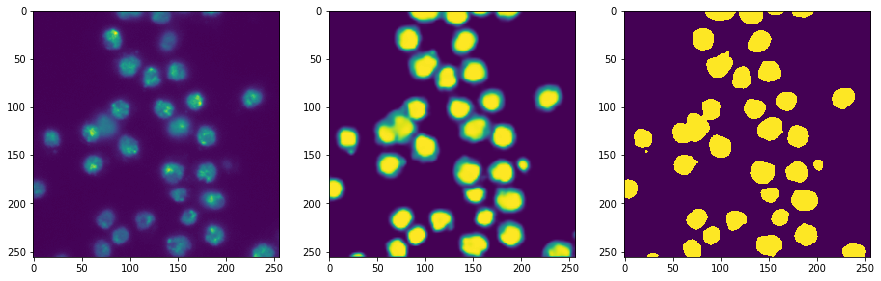

Image #: 58


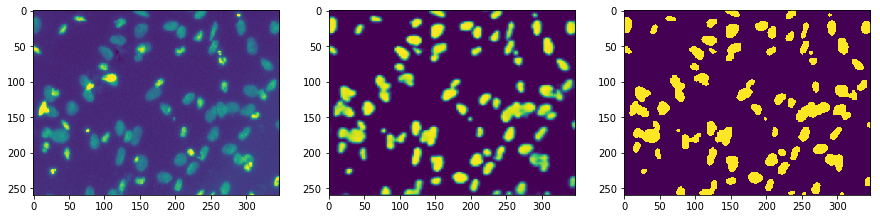

In [0]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [0]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,submission_filename)

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data